In [39]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers, Constant,
    RealParameter, Scenario, ScalarOutcome,
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)


from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress)
from ema_workbench.analysis import parcoords
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from MORDM_pyfile import MORDM_function

In [12]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

reference_scenario = Scenario('Reference Scenario', **dict({
    'discount rate 0': 2.5,
    'discount rate 1': 2.5,
    'discount rate 2': 2.5,
    'A.0_ID flood wave shape': 4,
    'A.1_Bmax': 175,
    'A.2_Bmax': 175,
    'A.3_Bmax': 175,
    'A.4_Bmax': 175,
    'A.5_Bmax': 175,
    'A.1_pfail': 0.5,
    'A.2_pfail': 0.5,
    'A.3_pfail': 0.5,
    'A.4_pfail': 0.5,
    'A.5_pfail': 0.5,
    'A.1_Brate': 1.5,
    'A.2_Brate': 1.5,
    'A.3_Brate': 1.5,
    'A.4_Brate': 1.5,
    'A.5_Brate': 1.5
}))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [42]:
#specify outcomes 
dike_model.outcomes = [ScalarOutcome('Expected Annual Damage', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('Dike Investment Costs', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('RfR Investment Costs', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('Evacuation Costs', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE)]

convergence_metrics = [ArchiveLogger(
                        "./archives",
                        [l.name for l in dike_model.levers],
                        [o.name for o in dike_model.outcomes],
                        base_filename="test3.tar.gz",
                        ),
                        EpsilonProgress(),
                        ]

In [ ]:
nfe = 1000
epsilons = 0.2

results, convergence = MORDM_function(dike_model, reference_scenario, nfe, epsilons, convergence_metrics)

[MainProcess/INFO] pool started with 4 workers

  0%|                                                 | 0/1000 [00:00<?, ?it/s]

In [37]:
from ema_workbench.em_framework.optimization import to_problem

def calculate_metrics(archives, reference_set):
    problem = to_problem(dike_model, searchover="levers", reference=reference_scenario)

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

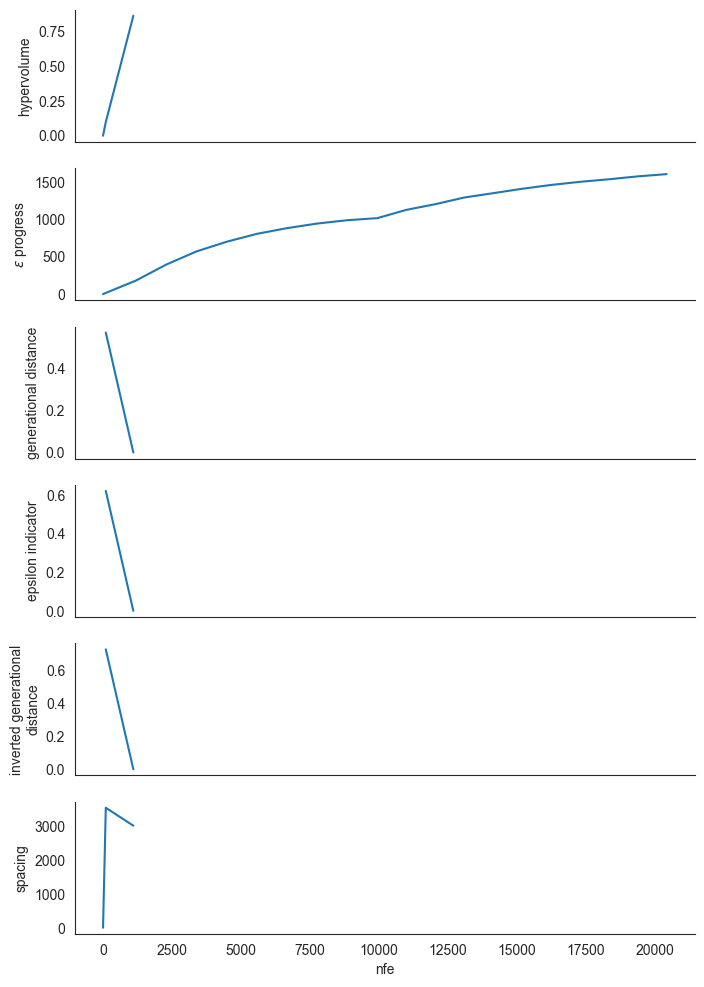

In [38]:
archives = ArchiveLogger.load_archives(f"./archives/test2.tar.gz")
for key in archives:
    if 'Unnamed: 0' in archives[key].columns:
        archives[key] = archives[key].drop(columns=['Unnamed: 0'])
reference_set = archives[max(archives.keys())] # this is the final archive
metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics, convergence)

plt.show()

In [40]:
results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,1,0,0,0,0,0,0,0,0,0,...,0,1,6,0,0,1.697466e+06,1.372338e+08,84600000.0,42.885867,0.000590
1,0,0,0,0,0,0,0,0,0,0,...,6,5,6,0,0,1.697466e+06,2.198137e+08,0.0,0.000000,0.001639
2,0,0,0,0,0,0,0,0,1,0,...,0,2,6,0,0,2.225318e+07,1.634730e+08,30700000.0,509.470907,0.012106
3,0,0,0,0,0,0,1,0,1,0,...,0,2,2,0,0,7.665815e+07,7.683623e+07,61400000.0,0.000000,0.086858
4,0,0,0,0,0,0,0,0,0,0,...,6,5,6,0,0,0.000000e+00,2.555309e+08,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1.862882e+08,3.901570e+07,30700000.0,4586.348968,0.068218
294,0,0,0,0,0,0,1,0,1,0,...,0,0,3,0,0,2.541706e+07,1.396418e+08,61400000.0,407.369982,0.003155
295,1,0,0,0,0,0,1,0,0,1,...,0,2,0,0,0,3.441051e+07,3.607124e+07,236500000.0,1880.616748,0.003749
296,1,0,0,0,0,0,0,1,0,1,...,0,0,3,0,0,1.050732e+07,1.003620e+08,236500000.0,709.311369,0.000633


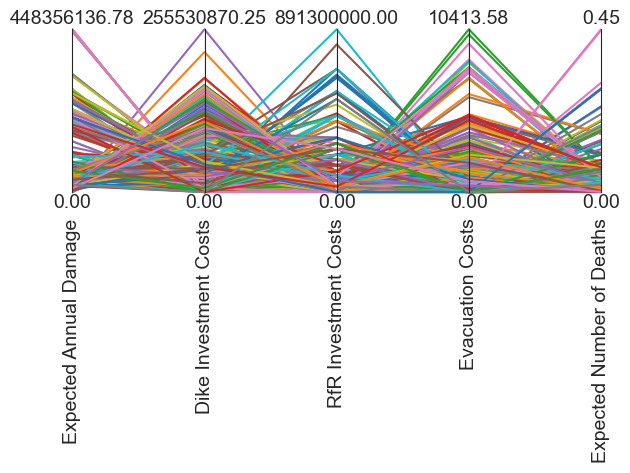

In [41]:
outcomes = results.loc[:, ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
# axes.invert_axis('Expected Number of Deaths') 
# plt.show()
